In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import gc
import glob

from netCDF4 import Dataset

from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects

In [2]:
def data_reader(variable:str, run_numbers:str):
    """
    This function is a data reader function that read data of 
    LAM 1km model using the specific variables: cloud, rad, turb and wind.
    
    variable: str
            "enter either rad or wind in strings as variable"
            E.g. data_reader("wind") or data_reader("rad")
    run_numbers: str:
           "enter either 031220, 031220_mp8_christian, 031220_mynn_l3, 031220_no_edmf, 031220_ysu"
    """
    
    path = f'/glade/campaign/uwyo/wyom0122/lam/new_runs/{run_numbers}/RESTART_*'
    data = f'wrfout_{variable}_d02_2020-03-1[3-4]*'
    res = np.sort(glob.glob(f'{path}/{data}'))
    
    elements_to_remove = [f'/glade/campaign/uwyo/wyom0122/lam/new_runs/{run_numbers}/RESTART_B/wrfout_{variable}_d02_2020-03-13_00_00_00',
                      f'/glade/campaign/uwyo/wyom0122/lam/new_runs/{run_numbers}/RESTART_D/wrfout_{variable}_d02_2020-03-13_06_00_00',
                      f'/glade/campaign/uwyo/wyom0122/lam/new_runs/{run_numbers}/RESTART_E/wrfout_{variable}_d02_2020-03-13_12_00_00',
                      f'/glade/campaign/uwyo/wyom0122/lam/new_runs/{run_numbers}/RESTART_F/wrfout_{variable}_d02_2020-03-13_18_30_00']
    
    array = np.delete(res, np.where(np.isin(res, elements_to_remove)))

    return array

In [3]:
radar1 = data_reader(variable="rad", run_numbers="031220")
wind1 = data_reader(variable="wind", run_numbers="031220")


radar2 = data_reader(variable="rad", run_numbers="031220_mp8_christian")
wind2 = data_reader(variable="wind", run_numbers="031220_mp8_christian")

radar3 = data_reader(variable="rad", run_numbers="031220_mynn_l3")
wind3 = data_reader(variable="wind", run_numbers="031220_mynn_l3")


radar4 = data_reader(variable="rad", run_numbers="031220_no_edmf")
wind4 = data_reader(variable="wind", run_numbers="031220_no_edmf")

radar5 = data_reader(variable="rad", run_numbers="031220_ysu")
wind5 = data_reader(variable="wind", run_numbers="031220_ysu")

In [4]:
def combining_dataarray(data, var):
    # appending the radar dataset into one dataset
    dataset = []
    for index, ncfile in enumerate(data):
        ds = xr.open_dataset(ncfile, engine='netcdf4')
        
        ds_var = ds[var]
        dataset.append(ds_var)
        
    # Concat dataset over time
    dd = xr.concat(dataset, dim='Time')
    return dd

In [5]:
radar_ds1 = combining_dataarray(radar1, 'RAINNC')
time_ds1 = combining_dataarray(radar1, 'Times')

radar_ds2 = combining_dataarray(radar2, 'RAINNC')
time_ds2 = combining_dataarray(radar2, 'Times')

radar_ds3 = combining_dataarray(radar3, 'RAINNC')
time_ds3 = combining_dataarray(radar3, 'Times')

radar_ds4 = combining_dataarray(radar4, 'RAINNC')
time_ds4 = combining_dataarray(radar4, 'Times')

radar_ds5 = combining_dataarray(radar5, 'RAINNC')
time_ds5 = combining_dataarray(radar5, 'Times')

In [6]:
latitude = combining_dataarray(wind1, 'XLAT')
longitude = combining_dataarray(wind1, 'XLONG')

In [7]:
# Combine dataArray
dataset = xr.Dataset({
    'rainnc1': radar_ds1,
    'rainnc2': radar_ds2,
    'rainnc3': radar_ds3,
    'rainnc4': radar_ds4,
    'rainnc5': radar_ds5,
    'latitude': latitude,
    'longitude': longitude,
    # 'W': W,
    # 'times': times,
})

In [8]:
dataset

<xarray.Dataset>
Dimensions:    (Time: 49, south_north: 1080, west_east: 1080)
Coordinates:
    XLAT       (Time, south_north, west_east) float32 67.6 67.6 ... 76.94 76.94
    XLONG      (Time, south_north, west_east) float32 -4.853 -4.83 ... 29.77
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    rainnc1    (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0
    rainnc2    (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0
    rainnc3    (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0
    rainnc4    (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0
    rainnc5    (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0
    latitude   (Time, south_north, west_east) float32 67.6 67.6 ... 76.94 76.94
    longitude  (Time, south_north, west_east) float32 -4.853 -4.83 ... 29.77

In [9]:
CAO_start_time1 = dataset['rainnc1'][8]  # start time -- March 13th at 4:00:00
CAO_end_time1 = dataset['rainnc1'][48] # end time -- March 14th at 00:00:00

CAO_start_time2 = dataset['rainnc2'][8]  # start time -- March 13th at 4:00:00
CAO_end_time2 = dataset['rainnc2'][48] # end time -- March 14th at 00:00:00

CAO_start_time3 = dataset['rainnc3'][8]  # start time -- March 13th at 4:00:00
CAO_end_time3 = dataset['rainnc3'][48] # end time -- March 14th at 00:00:00

CAO_start_time4 = dataset['rainnc4'][8]  # start time -- March 13th at 4:00:00
CAO_end_time4 = dataset['rainnc4'][48] # end time -- March 14th at 00:00:00

CAO_start_time5 = dataset['rainnc5'][8]  # start time -- March 13th at 4:00:00
CAO_end_time5 = dataset['rainnc5'][48] # end time -- March 14th at 00:00:00

In [10]:
entire_period1 = CAO_end_time1 - CAO_start_time1
entire_period2 = CAO_end_time2 - CAO_start_time2
entire_period3 = CAO_end_time3 - CAO_start_time3
entire_period4 = CAO_end_time4 - CAO_start_time4
entire_period5 = CAO_end_time5 - CAO_start_time5

In [11]:
ensemble_mean = (entire_period1 + entire_period2 +  entire_period3 +  entire_period4 +  entire_period5) / 5
ensemble_mean

<xarray.DataArray (south_north: 1080, west_east: 1080)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.9434774e+00, 2.7582018e+00, ..., 1.6584292e-01,
        1.5981358e-01, 0.0000000e+00],
       [0.0000000e+00, 2.8324416e+00, 2.6607432e+00, ..., 1.6515081e-01,
        1.6027358e-01, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.5118497e-03,
        1.5270191e-03, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.5745230e-03,
        1.5921580e-03, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)
Coordinates:
    XLAT     (south_north, west_east) float32 67.6 67.6 67.61 ... 76.94 76.94
    XLONG    (south_north, west_east) float32 -4.853 -4.83 ... 29.73 29.77
Dimensions without coordinates: south_north, west_east

In [12]:
# ensemble_mean.to_netcdf('./saved-files/ensemble-mean1-LAM1km.nc')

In [13]:
ensemble_mean = xr.open_dataarray('./saved-files/ensemble-mean1-LAM1km.nc')
ensemble_mean

<xarray.DataArray (south_north: 1080, west_east: 1080)>
[1166400 values with dtype=float32]
Coordinates:
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east

## Ensemble Mean

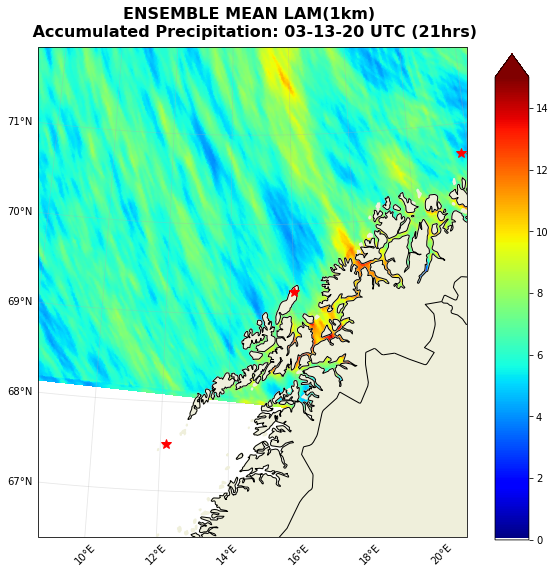

In [14]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})
# set extent
extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
ax.set_extent(extent)  # set extent of map


# plotting coastlines at a very high resolution: 10m
ax.coastlines(resolution='10m', zorder=7)
# add borders
ax.add_feature(cfeature.BORDERS, zorder=7)
# add land
ax.add_feature(cfeature.LAND, linewidth=1.5, alpha=1, zorder=6)
# add grid lines
gl = ax.gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
# add terrain
# ax.add_feature(cfeature.GSHHSFeature(scale='high'))
# Radar locations
ax.plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
ax.plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
ax.plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE

    
    

#     # # Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)



# # change time to moth, day, year, hours and minutes
norm = Normalize(vmin=0, vmax=15)

cs = ax.pcolormesh(ensemble_mean['XLONG'], 
                   ensemble_mean['XLAT'], 
                   ensemble_mean,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )

# levels = np.arange(0, 15.01, 0.5)
# cs = ax.contourf(ensemble_mean['XLONG'], 
#                    ensemble_mean['XLAT'], 
#                    ensemble_mean,
#                    transform=ccrs.PlateCarree(),
#                     cmap=new_cmap,
#                     levels=levels
#                       )


ax.set_title(
        f"ENSEMBLE MEAN LAM(1km) \n Accumulated Precipitation: 03-13-20 UTC (21hrs)", fontweight='bold', fontsize=16, pad=11)

# # # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.85, 0.12, 0.047, 0.75])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
# cbar.set_label("Radar \Precipitation[mm]", fontsize=15)

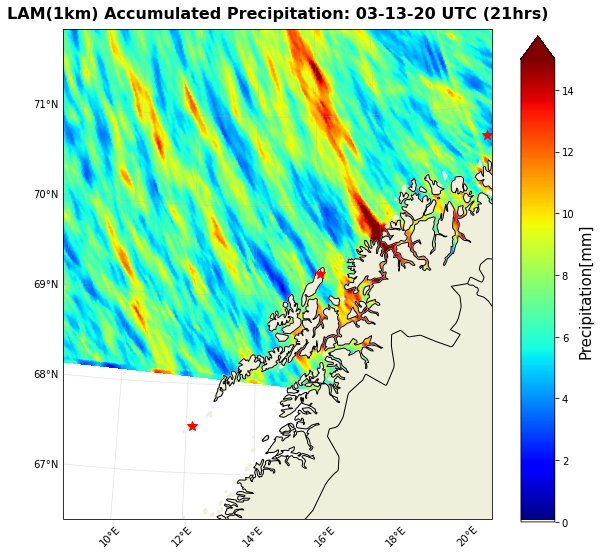

In [15]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})
# set extent
extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
ax.set_extent(extent)  # set extent of map


# plotting coastlines at a very high resolution: 10m
ax.coastlines(resolution='10m', zorder=7)
# add borders
ax.add_feature(cfeature.BORDERS, zorder=7)
# add land
ax.add_feature(cfeature.LAND, linewidth=1.5, alpha=1, zorder=6)
# add grid lines
gl = ax.gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
# add terrain
# ax.add_feature(cfeature.GSHHSFeature(scale='high'))
# Radar locations
ax.plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
ax.plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
ax.plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE

    
    

#     # # Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)



# # change time to moth, day, year, hours and minutes
norm = Normalize(vmin=0, vmax=15)

cs = ax.pcolormesh(entire_period1['XLONG'], 
                   entire_period1['XLAT'], 
                   entire_period1,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )



ax.set_title(
        f"LAM(1km) Accumulated Precipitation: 03-13-20 UTC (21hrs)", fontweight='bold', fontsize=16, pad=11)

# # # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.85, 0.12, 0.047, 0.75])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Precipitation[mm]", fontsize=15)

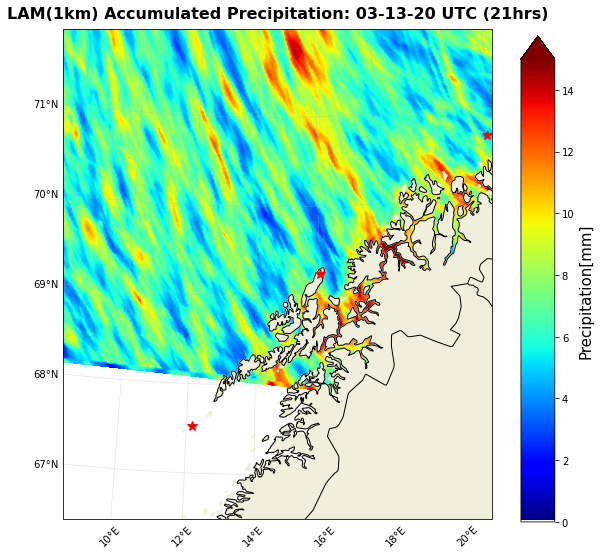

In [16]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})
# set extent
extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
ax.set_extent(extent)  # set extent of map


# plotting coastlines at a very high resolution: 10m
ax.coastlines(resolution='10m', zorder=7)
# add borders
ax.add_feature(cfeature.BORDERS, zorder=7)
# add land
ax.add_feature(cfeature.LAND, linewidth=1.5, alpha=1, zorder=6)
# add grid lines
gl = ax.gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
# add terrain
# ax.add_feature(cfeature.GSHHSFeature(scale='high'))
# Radar locations
ax.plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
ax.plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
ax.plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE

    
    

#     # # Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)



# # change time to moth, day, year, hours and minutes
norm = Normalize(vmin=0, vmax=15)

cs = ax.pcolormesh(entire_period2['XLONG'], 
                   entire_period2['XLAT'], 
                   entire_period2,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )



ax.set_title(
        f"LAM(1km) Accumulated Precipitation: 03-13-20 UTC (21hrs)", fontweight='bold', fontsize=16, pad=11)

# # # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.85, 0.12, 0.047, 0.75])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Precipitation[mm]", fontsize=15)

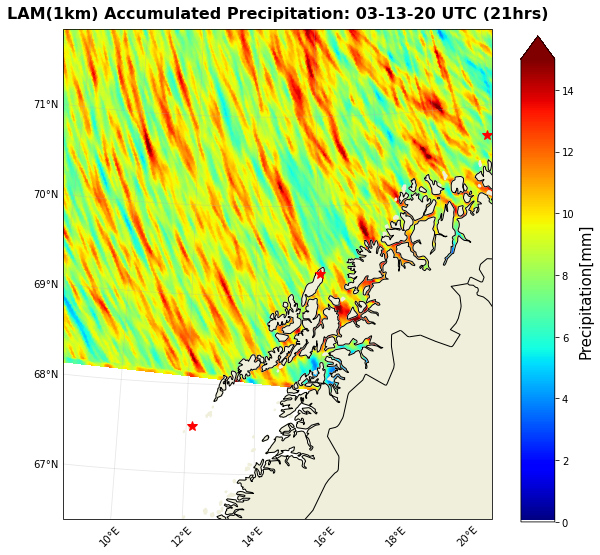

In [17]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})
# set extent
extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
ax.set_extent(extent)  # set extent of map


# plotting coastlines at a very high resolution: 10m
ax.coastlines(resolution='10m', zorder=7)
# add borders
ax.add_feature(cfeature.BORDERS, zorder=7)
# add land
ax.add_feature(cfeature.LAND, linewidth=1.5, alpha=1, zorder=6)
# add grid lines
gl = ax.gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
# add terrain
# ax.add_feature(cfeature.GSHHSFeature(scale='high'))
# Radar locations
ax.plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
ax.plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
ax.plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE

    
    

#     # # Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)



# # change time to moth, day, year, hours and minutes
norm = Normalize(vmin=0, vmax=15)

cs = ax.pcolormesh(entire_period3['XLONG'], 
                   entire_period3['XLAT'], 
                   entire_period3,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )



ax.set_title(
        f"LAM(1km) Accumulated Precipitation: 03-13-20 UTC (21hrs)", fontweight='bold', fontsize=16, pad=11)

# # # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.85, 0.12, 0.047, 0.75])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Precipitation[mm]", fontsize=15)

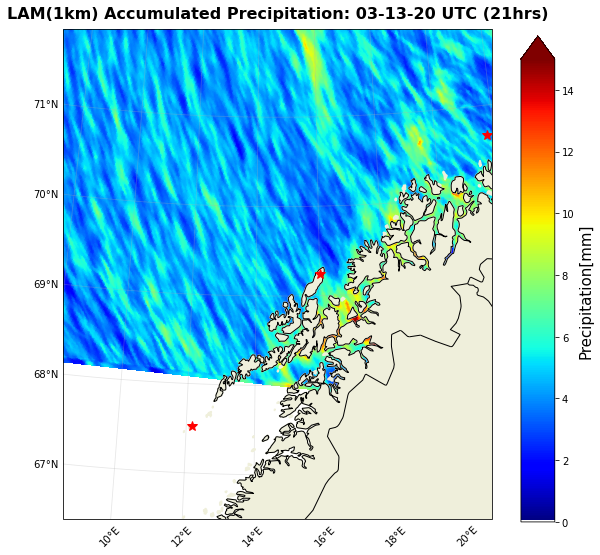

In [18]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})
# set extent
extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
ax.set_extent(extent)  # set extent of map


# plotting coastlines at a very high resolution: 10m
ax.coastlines(resolution='10m', zorder=7)
# add borders
ax.add_feature(cfeature.BORDERS, zorder=7)
# add land
ax.add_feature(cfeature.LAND, linewidth=1.5, alpha=1, zorder=6)
# add grid lines
gl = ax.gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
# add terrain
# ax.add_feature(cfeature.GSHHSFeature(scale='high'))
# Radar locations
ax.plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
ax.plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
ax.plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE

    
    

#     # # Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)



# # change time to moth, day, year, hours and minutes
norm = Normalize(vmin=0, vmax=15)

cs = ax.pcolormesh(entire_period4['XLONG'], 
                   entire_period4['XLAT'], 
                   entire_period4,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )



ax.set_title(
        f"LAM(1km) Accumulated Precipitation: 03-13-20 UTC (21hrs)", fontweight='bold', fontsize=16, pad=11)

# # # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.85, 0.12, 0.047, 0.75])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Precipitation[mm]", fontsize=15)

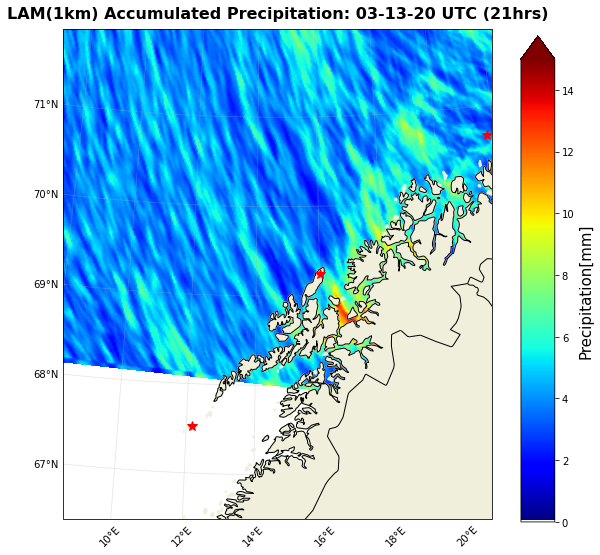

In [19]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})
# set extent
extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
ax.set_extent(extent)  # set extent of map


# plotting coastlines at a very high resolution: 10m
ax.coastlines(resolution='10m', zorder=7)
# add borders
ax.add_feature(cfeature.BORDERS, zorder=7)
# add land
ax.add_feature(cfeature.LAND, linewidth=1.5, alpha=1, zorder=6)
# add grid lines
gl = ax.gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
# add terrain
# ax.add_feature(cfeature.GSHHSFeature(scale='high'))
# Radar locations
ax.plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
ax.plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
ax.plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
        transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE

    
    

#     # # Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)



# # change time to moth, day, year, hours and minutes
norm = Normalize(vmin=0, vmax=15)

cs = ax.pcolormesh(entire_period5['XLONG'], 
                   entire_period5['XLAT'], 
                   entire_period5,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )



ax.set_title(
        f"LAM(1km) Accumulated Precipitation: 03-13-20 UTC (21hrs)", fontweight='bold', fontsize=16, pad=11)

# # # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.85, 0.12, 0.047, 0.75])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Precipitation[mm]", fontsize=15)

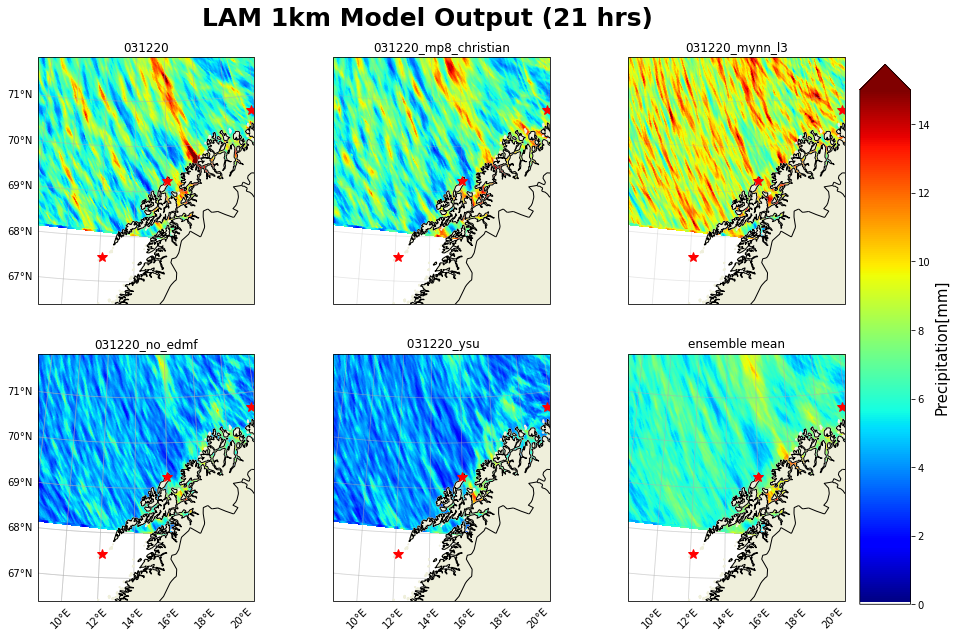

In [20]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})

ax = ax.flatten()

names = ['031220', '031220_mp8_christian', '031220_mynn_l3', '031220_no_edmf', ' 031220_ysu', 'ensemble mean']

for i, v in enumerate(ax):
    # set extent
    extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
    ax[i].set_extent(extent)  # set extent of map
    ax[i].set_title(names[i])


    # plotting coastlines at a very high resolution: 10m
    ax[i].coastlines(resolution='10m', zorder=7)
    # add borders
    ax[i].add_feature(cfeature.BORDERS, zorder=7)
    # add land
    ax[i].add_feature(cfeature.LAND, linewidth=1.5, alpha=1, zorder=6)
    # add grid lines
    gl = ax[i].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=False
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
    # add terrain
    # ax.add_feature(cfeature.GSHHSFeature(scale='high'))
    # Radar locations
    ax[i].plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
    ax[i].plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
    ax[i].plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE
    


# # Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)

norm = Normalize(vmin=0, vmax=15)



# # change time to moth, day, year, hours and minutes
norm = Normalize(vmin=0, vmax=15)
    
    

cs = ax[0].pcolormesh(entire_period1['XLONG'], 
                   entire_period1['XLAT'], 
                   entire_period1,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )
gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=True

cs = ax[1].pcolormesh(entire_period2['XLONG'], 
                   entire_period2['XLAT'], 
                   entire_period2,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )


cs = ax[2].pcolormesh(entire_period3['XLONG'], 
                   entire_period3['XLAT'], 
                   entire_period3,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )


cs = ax[3].pcolormesh(entire_period4['XLONG'], 
                   entire_period4['XLAT'], 
                   entire_period4,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )
gl = ax[3].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=True
gl = ax[3].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}

cs = ax[4].pcolormesh(entire_period5['XLONG'], 
                   entire_period5['XLAT'], 
                   entire_period5,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )
gl = ax[4].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}


cs = ax[5].pcolormesh(ensemble_mean['XLONG'], 
                   ensemble_mean['XLAT'], 
                   ensemble_mean,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )
gl = ax[5].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}


# # # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.90, 0.12, 0.047, 0.75])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Precipitation[mm]", fontsize=15)

fig.suptitle('LAM 1km Model Output (21 hrs)', y=0.95, fontweight='bold', fontsize=25)
fig.savefig('Combined-WRF-sim.png', dpi=500, bbox_inches='tight')